In [5]:
pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-014ceyq0
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-014ceyq0
  Running command git submodule update --init --recursive -q


In [6]:
import warnings
warnings.filterwarnings("ignore")
import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, UpSampling3D, Conv2DTranspose, concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session


import numpy as np
from numpy import unravel_index
import pandas as pd

from os import listdir
import os, os.path

import glob

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import skimage.measure
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics import r2_score

from PIL import Image

import re
import gc

import time

In [7]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Loaded: data_2_105_74
(200, 96, 96, 3)
Loaded: data_2_91_89
(200, 96, 96, 3)
Loaded: data_2_115_65
(200, 96, 96, 3)
Loaded: data_4_105_74
(200, 96, 96, 3)
Loaded: data_4_115_65
(200, 96, 96, 3)
Loaded: data_6_105_74
(200, 96, 96, 3)
Loaded: data_4_91_89
(200, 96, 96, 3)
Loaded: data_6_91_89
(200, 96, 96, 3)
Loaded: data_6_115_65
(200, 96, 96, 3)
0.0
1.0


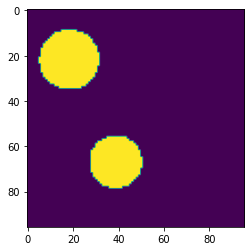

In [9]:
filepath = '/content/drive/MyDrive/Research_FractureStressMLModeling/FractureStressColab/ColabData/High_Porosity/3-channel data/Non_Uniform_Sized_Pores/Images96x96_newData(Normalized_maxpool_3D)'
imageDict = {}
for filename in os.listdir(filepath):
    path = os.path.join(filepath, filename)
    key = filename.split('.')[0]
    imageDict[key] = np.load(path,allow_pickle=True)
    print('Loaded: '+ key)
    print(imageDict[key].shape)


plt.imshow(imageDict['data_2_105_74'][70,:,:,0])
print(imageDict['data_2_105_74'][70].min())
print(imageDict['data_2_105_74'][70].max())

Loaded: data_2_115_65
(200, 96, 96, 3)
Loaded: data_2_105_74
(200, 96, 96, 3)
Loaded: data_4_105_74
(200, 96, 96, 3)
Loaded: data_2_91_89
(200, 96, 96, 3)
Loaded: data_4_91_89
(200, 96, 96, 3)
Loaded: data_4_115_65
(200, 96, 96, 3)
Loaded: data_6_115_65
(200, 96, 96, 3)
Loaded: data_6_105_74
(200, 96, 96, 3)
Loaded: data_6_91_89
(200, 96, 96, 3)
-0.07724143392053406
4.328437686141806


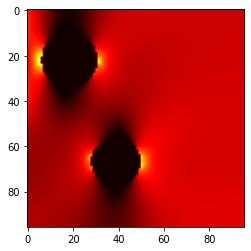

In [10]:
DIR = '/content/drive/MyDrive/Research_FractureStressMLModeling/FractureStressColab/ColabData/High_Porosity/3-channel data/Non_Uniform_Sized_Pores/Stress96x96_newData(Normalized_maxpool_3D)'
matrixDict = {}
for filename in os.listdir(DIR):
    path = os.path.join(DIR, filename)
    key = filename.split('.')[0]
    matrixDict[key] = np.load(path)
    print('Loaded: '+ key)
    print(matrixDict[key].shape)
    
plt.imshow(matrixDict['data_2_105_74'][70][:,:,0], cmap='hot')
print(matrixDict['data_2_105_74'][70].min())
print(matrixDict['data_2_105_74'][70].max())

In [11]:
# Combine X datas
x = np.concatenate((imageDict['data_2_105_74'], imageDict['data_2_115_65'],
                    imageDict['data_2_91_89'],imageDict['data_4_105_74'],imageDict['data_4_115_65'],
                    imageDict['data_4_91_89'], imageDict['data_6_91_89'], imageDict['data_6_105_74'],
                    imageDict['data_6_115_65'],), axis = 0)   
x.shape

(1800, 96, 96, 3)

In [12]:
# Combine Y datas 
y = np.concatenate((matrixDict['data_2_105_74'], matrixDict['data_2_115_65'],
                    matrixDict['data_2_91_89'],matrixDict['data_4_105_74'],matrixDict['data_4_115_65'],
                    matrixDict['data_4_91_89'], matrixDict['data_6_91_89'], matrixDict['data_6_105_74'],
                    matrixDict['data_6_115_65'],), axis = 0) 
y.shape

(1800, 96, 96, 3)

In [13]:
# Since there are total 1100 images,
# training data is 90% : 990
# testing data is 10% : 110
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.1, 
                                                    random_state=42)

print('Shape of x_train',x_train.shape,'\n',
      'Shape of x_test',x_test.shape,'\n', 
      'Shape of y_train',y_train.shape,'\n', 
      'Shape of y_test',y_test.shape)

Shape of x_train (1620, 96, 96, 3) 
 Shape of x_test (180, 96, 96, 3) 
 Shape of y_train (1620, 96, 96, 3) 
 Shape of y_test (180, 96, 96, 3)


In [14]:
# For observing effects of data size, 

idx = np.random.randint(1620, size=100)
x_train_100 = x_train[idx,:,:,:]
y_train_100 = y_train[idx,:,:,:]
print('Shape of x_train_100',x_train_100.shape,'\n',
      'Shape of y_train_100',y_train_100.shape,'\n')

idx = np.random.randint(1620, size=300)
x_train_300 = x_train[idx,:,:,:]
y_train_300 = y_train[idx,:,:,:]
print('Shape of x_train_300',x_train_300.shape,'\n',
      'Shape of y_train_300',y_train_300.shape,'\n')

idx = np.random.randint(1620, size=500)
x_train_500 = x_train[idx,:,:,:]
y_train_500 = y_train[idx,:,:,:]
print('Shape of x_train_500',x_train_500.shape,'\n',
      'Shape of y_train_500',y_train_500.shape,'\n')

idx = np.random.randint(1620, size=700)
x_train_700 = x_train[idx,:,:,:]
y_train_700 = y_train[idx,:,:,:]
print('Shape of x_train_700',x_train_700.shape,'\n',
      'Shape of y_train_700',y_train_700.shape,'\n')

idx = np.random.randint(1620, size=900)
x_train_900 = x_train[idx,:,:,:]
y_train_900 = y_train[idx,:,:,:]
print('Shape of x_train_900',x_train_900.shape,'\n',
      'Shape of y_train_900',y_train_900.shape,'\n')

idx = np.random.randint(1620, size=1100)
x_train_1100 = x_train[idx,:,:,:]
y_train_1100 = y_train[idx,:,:,:]
print('Shape of x_train_1100',x_train_1100.shape,'\n',
      'Shape of y_train_1100',y_train_1100.shape,'\n')

idx = np.random.randint(1620, size=1300)
x_train_1300 = x_train[idx,:,:,:]
y_train_1300 = y_train[idx,:,:,:]
print('Shape of x_train_1300',x_train_1300.shape,'\n',
      'Shape of y_train_1300',y_train_1300.shape,'\n')

x_train_1620 = np.copy(x_train)
y_train_1620 = np.copy(y_train)
print('Shape of x_train_1620',x_train_1620.shape,'\n',
      'Shape of y_train_1620',y_train_1620.shape)

Shape of x_train_100 (100, 96, 96, 3) 
 Shape of y_train_100 (100, 96, 96, 3) 

Shape of x_train_300 (300, 96, 96, 3) 
 Shape of y_train_300 (300, 96, 96, 3) 

Shape of x_train_500 (500, 96, 96, 3) 
 Shape of y_train_500 (500, 96, 96, 3) 

Shape of x_train_700 (700, 96, 96, 3) 
 Shape of y_train_700 (700, 96, 96, 3) 

Shape of x_train_900 (900, 96, 96, 3) 
 Shape of y_train_900 (900, 96, 96, 3) 

Shape of x_train_1100 (1100, 96, 96, 3) 
 Shape of y_train_1100 (1100, 96, 96, 3) 

Shape of x_train_1300 (1300, 96, 96, 3) 
 Shape of y_train_1300 (1300, 96, 96, 3) 

Shape of x_train_1620 (1620, 96, 96, 3) 
 Shape of y_train_1620 (1620, 96, 96, 3)


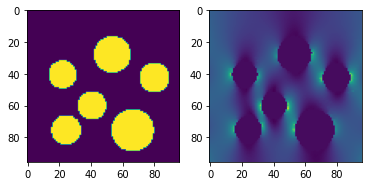

[[[1.50915549 1.50915549 1.50915549]
  [1.49638033 1.49638033 1.49638033]
  [1.48358072 1.48358072 1.48358072]
  ...
  [1.89815604 1.89815604 1.89815604]
  [2.00116282 2.00116282 2.00116282]
  [2.1040073  2.1040073  2.1040073 ]]

 [[1.50962807 1.50962807 1.50962807]
  [1.49683083 1.49683083 1.49683083]
  [1.48400911 1.48400911 1.48400911]
  ...
  [1.90047731 1.90047731 1.90047731]
  [2.00367871 2.00367871 2.00367871]
  [2.10671779 2.10671779 2.10671779]]

 [[1.50613084 1.50613084 1.50613084]
  [1.49433236 1.49433236 1.49433236]
  [1.48250941 1.48250941 1.48250941]
  ...
  [1.90148279 1.90148279 1.90148279]
  [1.99181817 1.99181817 1.99181817]
  [2.08199124 2.08199124 2.08199124]]

 ...

 [[2.3916887  2.3916887  2.3916887 ]
  [2.28453469 2.28453469 2.28453469]
  [2.17473628 2.17473628 2.17473628]
  ...
  [1.3030122  1.3030122  1.3030122 ]
  [1.36369059 1.36369059 1.36369059]
  [1.41769089 1.41769089 1.41769089]]

 [[2.39028376 2.39028376 2.39028376]
  [2.28295635 2.28295635 2.28295635]


In [15]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(x_train_100[71][:,:,0])
f.add_subplot(1,2, 2)
plt.imshow(y_train_100[71][:,:,0])
plt.show(block=True)
print(y_train_100[70])

In [16]:
# A function calculating Percentage Error
def percentage_err_3channels(y_pred, y_test):
    arr = []
    for idx in range(len(y_test)):
        for x in range(y_test.shape[1]):
            #for y in range(y_test.shape[2]):
            for z in range(y_test.shape[3]):
                if(0 in y_test[idx]):
                    continue
                else:
                    err = ((np.abs(y_pred[idx] - y_test[idx]) / y_test[idx]) * 100)
                    arr.append(err)
    
    return abs(np.mean(arr))

# A function calculating Percentage Error with 1-channel
def percentage_err_1channel(y_pred, y_test): 
    arr = []
    for idx in range(len(y_test)):
        for x in range(y_test.shape[1]):
            #for y in range(y_test.shape[2]):
            if(0 in y_test[idx,x,:]):
                continue
            else:
                err = ((np.abs(y_pred[idx] - y_test[idx]) / y_test[idx]) * 100)
                arr.append(err)
    
    return np.mean(arr)

# A Function to calculate R2 for each pore
def calculateR2_for_pores(preds, y_test, AVMat):
    b = []
    c = []
    TSS = 0
    RSS = 0
    
    for i in range(len(y_test)):
        b = ((y_test[i] - preds[i])**2)
        RSS = RSS + b
        
    for i in range(len(y_test)):
        c = ((y_test[i] -  AVMat)**2)
        TSS = TSS + c

    R2 = 1 - (RSS/TSS)
    return R2.mean()
    
# A function to obtain AVMat
def calculateAVMat(y_test):
    AVMat = np.zeros((96,96,3))

    for i in range(len(y_test)):
        AVMat = AVMat + (y_test[i])
    
    AVMat = AVMat/len(y_test)
    
    return AVMat

# A function calculates R2 score
def calculateR2(preds, y_test):
    b = []
    c = []
    TSS = 0
    RSS = 0
    AVMat = np.zeros((96,96,3))

    for i in range(len(y_test)):
        AVMat = AVMat + (y_test[i])

    AVMat = AVMat/len(y_test)

    for i in range(len(y_test)):
        b = ((y_test[i] - preds[i])**2)
        RSS = RSS + b

    for i in range(len(y_test)):
        c = ((y_test[i] -  AVMat)**2)
        TSS = TSS + c

    R2 = 1 - (RSS/TSS)
    return R2.mean()

# A function calculates MSE
def calculateMSE(dataA, dataB):
    errArray = []
    for i in range(len(dataA)):
        err = np.sum((dataA[i] - dataB[i]) ** 2)
        err /= float(dataA[i].shape[0] * dataA[i].shape[1])
        errArray.append(err)

    return sum(errArray) / len(errArray)

In [17]:
# Function reset the model
def reset_keras(model):
    sess = tf.compat.v1.keras.backend.get_session()
    clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    try:
        del model
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [18]:
# Setting training configuration
batch_size = 16 #originally 100
epochs = 100 #30 originally
AVMat = []
R2Array_train = []
R2Array_test = []
MSEArray_train = []
MSEArray_test = []
err_train_3ch = []
err_test_3ch = []
err_train_1ch = []
err_test_1ch = []

In [19]:
AVMat = calculateAVMat(y_train)

In [20]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [50]:
from keras_applications.densenet import preprocess_input
BACKBONE = 'densenet201'
preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                           

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.594025 to fit



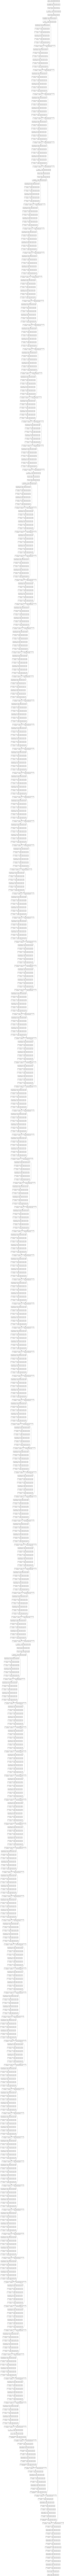

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [23]:
model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam())

In [24]:
#Training with 100 data
%%time
model.fit(x_train_100, y_train_100, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
7/7 [==============================] - 41s 786ms/step - loss: 0.6244
Epoch 2/100
7/7 [==============================] - 1s 111ms/step - loss: 0.4218
Epoch 3/100
7/7 [==============================] - 1s 112ms/step - loss: 0.3539
Epoch 4/100
7/7 [==============================] - 1s 113ms/step - loss: 0.3232
Epoch 5/100
7/7 [==============================] - 1s 113ms/step - loss: 0.3046
Epoch 6/100
7/7 [==============================] - 1s 113ms/step - loss: 0.2935
Epoch 7/100
7/7 [==============================] - 1s 112ms/step - loss: 0.2857
Epoch 8/100
7/7 [==============================] - 1s 113ms/step - loss: 0.2811
Epoch 9/100
7/7 [==============================] - 1s 113ms/step - loss: 0.2776
Epoch 10/100
7/7 [==============================] - 1s 114ms/step - loss: 0.2749
Epoch 11/100
7/7 [==============================] - 1s 112ms/step - loss: 0.2726
Epoch 12/100
7/7 [==============================] - 1s 113ms/step - loss: 0.2712
Epoch 13/100
7/7 [==================

In [25]:
%%time
preds_train = model.predict(x_train_100)
preds = model.predict(x_test)

6/6 [==============================] - 2s 444ms/step
CPU times: user 7.82 s, sys: 93.3 ms, total: 7.91 s
Wall time: 7.89 s


In [26]:
%%time
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_100))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_100))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_100))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

reset_keras(model)

[0.23204633356186577]
[0.20337417782773684]
1937
CPU times: user 1.39 s, sys: 37.7 ms, total: 1.43 s
Wall time: 1.49 s


In [27]:
#Train with 300 data points

model.fit(x_train_300, y_train_300, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
19/19 [==============================] - 12s 371ms/step - loss: 0.2955
Epoch 2/100
19/19 [==============================] - 2s 118ms/step - loss: 0.2944
Epoch 3/100
19/19 [==============================] - 2s 118ms/step - loss: 0.2938
Epoch 4/100
19/19 [==============================] - 2s 119ms/step - loss: 0.2935
Epoch 5/100
19/19 [==============================] - 2s 119ms/step - loss: 0.2933
Epoch 6/100
19/19 [==============================] - 2s 119ms/step - loss: 0.2931
Epoch 7/100
19/19 [==============================] - 2s 120ms/step - loss: 0.2930
Epoch 8/100
19/19 [==============================] - 2s 119ms/step - loss: 0.2929
Epoch 9/100
19/19 [==============================] - 2s 119ms/step - loss: 0.2929
Epoch 10/100
19/19 [==============================] - 2s 120ms/step - loss: 0.2928
Epoch 11/100
19/19 [==============================] - 2s 118ms/step - loss: 0.2926
Epoch 12/100
19/19 [==============================] - 2s 119ms/step - loss: 0.2925
Epoch 13/100

In [28]:
%%time
preds_train = model.predict(x_train_300)
preds = model.predict(x_test)

6/6 [==============================] - 0s 52ms/step
CPU times: user 2.36 s, sys: 30.7 ms, total: 2.39 s
Wall time: 2.98 s


In [29]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_300))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_300))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_300))
MSEArray_test.append(calculateMSE(preds, y_test))

In [30]:
print(R2Array_train)
print(R2Array_test)

[0.23204633356186577, 0.20571409771444887]
[0.20337417782773684, 0.20910146148872202]


In [31]:
#Train with 500 data points

model.fit(x_train_500, y_train_500, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
32/32 [==============================] - 4s 122ms/step - loss: 0.2802
Epoch 2/100
32/32 [==============================] - 4s 121ms/step - loss: 0.2800
Epoch 3/100
32/32 [==============================] - 4s 122ms/step - loss: 0.2796
Epoch 4/100
32/32 [==============================] - 4s 122ms/step - loss: 0.2791
Epoch 5/100
32/32 [==============================] - 4s 120ms/step - loss: 0.2791
Epoch 6/100
32/32 [==============================] - 4s 121ms/step - loss: 0.2789
Epoch 7/100
32/32 [==============================] - 4s 121ms/step - loss: 0.2787
Epoch 8/100
32/32 [==============================] - 4s 121ms/step - loss: 0.2787
Epoch 9/100
32/32 [==============================] - 4s 121ms/step - loss: 0.2787
Epoch 10/100
32/32 [==============================] - 4s 122ms/step - loss: 0.2787
Epoch 11/100
32/32 [==============================] - 4s 121ms/step - loss: 0.2785
Epoch 12/100
32/32 [==============================] - 4s 122ms/step - loss: 0.2783
Epoch 13/100


In [32]:
%%time
preds_train = model.predict(x_train_500)
preds = model.predict(x_test)

6/6 [==============================] - 0s 50ms/step
CPU times: user 1.37 s, sys: 23.8 ms, total: 1.4 s
Wall time: 1.37 s


In [33]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_500))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_500))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_500))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[0.23204633356186577, 0.20571409771444887, 0.2340393216712099]
[0.20337417782773684, 0.20910146148872202, 0.21018920436131194]


In [34]:
#Train with 700 data points

model.fit(x_train_700, y_train_700, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
44/44 [==============================] - 5s 121ms/step - loss: 0.2858
Epoch 2/100
44/44 [==============================] - 5s 124ms/step - loss: 0.2854
Epoch 3/100
44/44 [==============================] - 5s 122ms/step - loss: 0.2852
Epoch 4/100
44/44 [==============================] - 5s 123ms/step - loss: 0.2849
Epoch 5/100
44/44 [==============================] - 5s 125ms/step - loss: 0.2848
Epoch 6/100
44/44 [==============================] - 6s 125ms/step - loss: 0.2846
Epoch 7/100
44/44 [==============================] - 5s 125ms/step - loss: 0.2844
Epoch 8/100
44/44 [==============================] - 5s 124ms/step - loss: 0.2844
Epoch 9/100
44/44 [==============================] - 5s 124ms/step - loss: 0.2844
Epoch 10/100
44/44 [==============================] - 5s 122ms/step - loss: 0.2843
Epoch 11/100
44/44 [==============================] - 5s 122ms/step - loss: 0.2843
Epoch 12/100
44/44 [==============================] - 5s 121ms/step - loss: 0.2842
Epoch 13/100


In [35]:
%%time
preds_train = model.predict(x_train_700)
preds = model.predict(x_test)

6/6 [==============================] - 0s 51ms/step
CPU times: user 3.9 s, sys: 33.6 ms, total: 3.93 s
Wall time: 3.91 s


In [36]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_700))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_700))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_700))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[0.23204633356186577, 0.20571409771444887, 0.2340393216712099, 0.22603882168920056]
[0.20337417782773684, 0.20910146148872202, 0.21018920436131194, 0.21071962773827724]


In [37]:
#Train with 900 data points

model.fit(x_train_900, y_train_900, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
57/57 [==============================] - 7s 122ms/step - loss: 0.2784
Epoch 2/100
57/57 [==============================] - 7s 122ms/step - loss: 0.2782
Epoch 3/100
57/57 [==============================] - 7s 122ms/step - loss: 0.2780
Epoch 4/100
57/57 [==============================] - 7s 124ms/step - loss: 0.2777
Epoch 5/100
57/57 [==============================] - 8s 132ms/step - loss: 0.2775
Epoch 6/100
57/57 [==============================] - 7s 123ms/step - loss: 0.2774
Epoch 7/100
57/57 [==============================] - 7s 124ms/step - loss: 0.2774
Epoch 8/100
57/57 [==============================] - 7s 123ms/step - loss: 0.2772
Epoch 9/100
57/57 [==============================] - 7s 122ms/step - loss: 0.2772
Epoch 10/100
57/57 [==============================] - 7s 121ms/step - loss: 0.2772
Epoch 11/100
57/57 [==============================] - 7s 121ms/step - loss: 0.2771
Epoch 12/100
57/57 [==============================] - 7s 121ms/step - loss: 0.2771
Epoch 13/100


In [38]:
%%time
preds_train = model.predict(x_train_900)
preds = model.predict(x_test)

6/6 [==============================] - 0s 49ms/step
CPU times: user 2.07 s, sys: 25 ms, total: 2.09 s
Wall time: 3.03 s


In [39]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_900))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_900))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_900))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[0.23204633356186577, 0.20571409771444887, 0.2340393216712099, 0.22603882168920056, 0.23069946834633373]
[0.20337417782773684, 0.20910146148872202, 0.21018920436131194, 0.21071962773827724, 0.21099652123743762]


In [40]:
#Train with 1100 data points

model.fit(x_train_1100, y_train_1100, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
69/69 [==============================] - 8s 121ms/step - loss: 0.2804
Epoch 2/100
69/69 [==============================] - 9s 127ms/step - loss: 0.2801
Epoch 3/100
69/69 [==============================] - 8s 122ms/step - loss: 0.2798
Epoch 4/100
69/69 [==============================] - 8s 123ms/step - loss: 0.2796
Epoch 5/100
69/69 [==============================] - 8s 123ms/step - loss: 0.2795
Epoch 6/100
69/69 [==============================] - 8s 122ms/step - loss: 0.2794
Epoch 7/100
69/69 [==============================] - 8s 122ms/step - loss: 0.2792
Epoch 8/100
69/69 [==============================] - 8s 121ms/step - loss: 0.2792
Epoch 9/100
69/69 [==============================] - 8s 121ms/step - loss: 0.2792
Epoch 10/100
69/69 [==============================] - 8s 121ms/step - loss: 0.2791
Epoch 11/100
69/69 [==============================] - 8s 121ms/step - loss: 0.2791
Epoch 12/100
69/69 [==============================] - 8s 121ms/step - loss: 0.2791
Epoch 13/100


In [41]:
%%time
preds_train = model.predict(x_train_1100)
preds = model.predict(x_test)

6/6 [==============================] - 0s 50ms/step
CPU times: user 2.4 s, sys: 33.1 ms, total: 2.44 s
Wall time: 2.38 s


In [42]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_1100))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_1100))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_1100))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[0.23204633356186577, 0.20571409771444887, 0.2340393216712099, 0.22603882168920056, 0.23069946834633373, 0.2174516120707137]
[0.20337417782773684, 0.20910146148872202, 0.21018920436131194, 0.21071962773827724, 0.21099652123743762, 0.21115558380973343]


In [43]:
#Train with 1300 data points

model.fit(x_train_1300, y_train_1300, 
          batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
82/82 [==============================] - 10s 120ms/step - loss: 0.2763
Epoch 2/100
82/82 [==============================] - 10s 121ms/step - loss: 0.2760
Epoch 3/100
82/82 [==============================] - 10s 122ms/step - loss: 0.2757
Epoch 4/100
82/82 [==============================] - 10s 124ms/step - loss: 0.2755
Epoch 5/100
82/82 [==============================] - 10s 122ms/step - loss: 0.2754
Epoch 6/100
82/82 [==============================] - 10s 121ms/step - loss: 0.2754
Epoch 7/100
82/82 [==============================] - 10s 120ms/step - loss: 0.2753
Epoch 8/100
82/82 [==============================] - 10s 121ms/step - loss: 0.2753
Epoch 9/100
82/82 [==============================] - 10s 121ms/step - loss: 0.2752
Epoch 10/100
82/82 [==============================] - 10s 121ms/step - loss: 0.2752
Epoch 11/100
82/82 [==============================] - 10s 121ms/step - loss: 0.2752
Epoch 12/100
82/82 [==============================] - 10s 126ms/step - loss: 0.2752
E

In [44]:
%%time
preds_train = model.predict(x_train_1300)
preds = model.predict(x_test)

6/6 [==============================] - 0s 50ms/step
CPU times: user 2.67 s, sys: 78.2 ms, total: 2.75 s
Wall time: 3.13 s


In [45]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_1300))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_1300))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_1300))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[0.23204633356186577, 0.20571409771444887, 0.2340393216712099, 0.22603882168920056, 0.23069946834633373, 0.2174516120707137, 0.22271627885969494]
[0.20337417782773684, 0.20910146148872202, 0.21018920436131194, 0.21071962773827724, 0.21099652123743762, 0.21115558380973343, 0.2114405351711909]


In [46]:
#Train with 1620 data points

model.fit(x_train_1620, y_train_1620, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
102/102 [==============================] - 12s 121ms/step - loss: 0.2779
Epoch 2/100
102/102 [==============================] - 12s 122ms/step - loss: 0.2777
Epoch 3/100
102/102 [==============================] - 12s 121ms/step - loss: 0.2774
Epoch 4/100
102/102 [==============================] - 12s 121ms/step - loss: 0.2773
Epoch 5/100
102/102 [==============================] - 12s 121ms/step - loss: 0.2772
Epoch 6/100
102/102 [==============================] - 12s 120ms/step - loss: 0.2771
Epoch 7/100
102/102 [==============================] - 13s 125ms/step - loss: 0.2771
Epoch 8/100
102/102 [==============================] - 12s 121ms/step - loss: 0.2770
Epoch 9/100
102/102 [==============================] - 12s 121ms/step - loss: 0.2770
Epoch 10/100
102/102 [==============================] - 12s 122ms/step - loss: 0.2770
Epoch 11/100
102/102 [==============================] - 12s 122ms/step - loss: 0.2770
Epoch 12/100
102/102 [==============================] - 12s 121

In [47]:
%%time
preds_train = model.predict(x_train_1620)
preds = model.predict(x_test)

6/6 [==============================] - 0s 70ms/step
CPU times: user 3.31 s, sys: 51.3 ms, total: 3.36 s
Wall time: 5.98 s


In [48]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_1620))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_1620))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_1620))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[0.23204633356186577, 0.20571409771444887, 0.2340393216712099, 0.22603882168920056, 0.23069946834633373, 0.2174516120707137, 0.22271627885969494, 0.22683281037490505]
[0.20337417782773684, 0.20910146148872202, 0.21018920436131194, 0.21071962773827724, 0.21099652123743762, 0.21115558380973343, 0.2114405351711909, 0.21143122130439962]
